# Ferromagnetic resonance

This notebook is designed to go with the ______ paper and showcase the code and the techniques that `mag2exp` included in the paper.

In [1]:
%config InlineBackend.figure_formats = ['svg']

Import packages

In [2]:
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as oc
import numpy as np
import mag2exp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import FuncFormatter
import matplotlib
plt.style.use('default')

Define the energy terms of the micromagnetic simulation.

In [3]:
system = mm.System(name="FMR_simulation")

H_max = 0.1/mm.consts.mu0
angle = 1 *np.pi/180  # Missalign the applied field by 1 degrees to break symmetry.
system.energy = (mm.Exchange(A=8.78e-12)
                 + mm.DMI(D=1.58e-3, crystalclass='T')
                 + mm.UniaxialAnisotropy(K=1e5, u=(0,0,1))
                 + mm.Zeeman(H=(0, H_max*np.sin(angle), H_max*np.cos(angle))))
system.energy

Exchange(A=8.78e-12) + DMI(D=0.00158, crystalclass='T') + UniaxialAnisotropy(K=100000.0, u=(0, 0, 1)) + Zeeman(H=(0, np.float64(1388.8183766712427), np.float64(79565.35151158909)))

Define the initial magnetisation as thr core and background of a skyrmion.

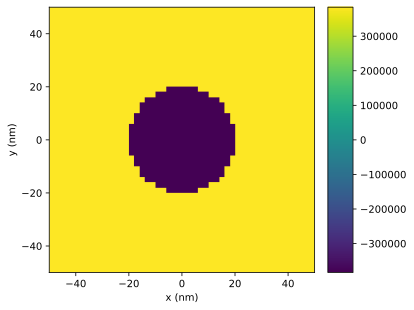

In [4]:
Ms = 384e3  # A/m
region = df.Region(p1=(-50e-9, -50e-9, 0), p2=(50e-9, 50e-9, 1e-9))
mesh = df.Mesh(region=region, cell=(2e-9, 2e-9, 1e-9))

def m_fun(pos):
    x, y, _ = pos
    
    r = 20e-9
    
    if x**2 + y**2 <= r**2:
        return (0, 0, -1)
    else:
        return (0, 0, 1)


system.m = df.Field(mesh, nvdim=3, value=m_fun, norm=Ms)
system.m.sel('z').z.mpl()

Minimise the energy

Running OOMMF (ExeOOMMFRunner)[2025-03-10T15:47:02]... (1.4 s)


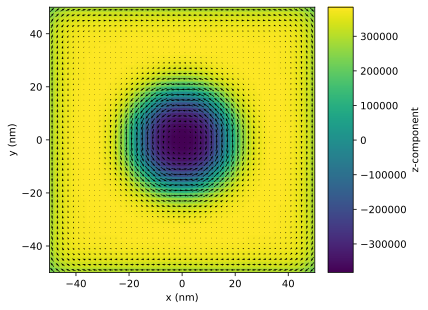

In [5]:
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.sel('z').mpl()

Define the dynamics

In [6]:
system.dynamics = mm.Damping(alpha=0.01) + mm.Precession(gamma0=2.211e5)

Perturb the system slightly by changing the magnitude of the applied field.

In [7]:
H_max *= 1.01
system.energy.zeeman.H = (0, H_max*np.sin(angle), H_max*np.cos(angle))

Let the system relax

In [8]:
td = oc.TimeDriver()
td.drive(system, t=10e-9, n=2000, verbose=2)

Running OOMMF (ExeOOMMFRunner):   0%|          | 0/2000 files written [00:00]

Running OOMMF (ExeOOMMFRunner)[2025-03-10T15:47:04] took 272.5 s


## Analyse the time dependent data

Import `micromagneticdata` and look at the drives that have been perfomed.

In [9]:
import micromagneticdata as micd

data = micd.Data("FMR_simulation")
data.info

drive_number        date      time           start_time adapter  \
0             0  2025-03-10  15:47:02  2025-03-10T15:47:02  oommfc   
1             1  2025-03-10  15:47:04  2025-03-10T15:47:04  oommfc   

  adapter_version      driver             end_time elapsed_time  success  \
0          0.64.1   MinDriver  2025-03-10T15:47:04     00:00:02     True   
1          0.64.1  TimeDriver  2025-03-10T15:51:37     00:04:33     True   

              t       n  
0           NaN     NaN  
1  1.000000e-08  2000.0

Select the `TimeDriver` and use `mag2exp` to obtain the FMR power and phase as `xarrays`.

In [10]:
drive = data[-1]

In [11]:
import mag2exp

power, phase = mag2exp.fmr.ringdown(drive)

Plot the power spectral density

In [12]:
matplotlib.rcParams.update({'font.size': 15})
def plot_power(power):
    fig, ax = plt.subplots(figsize=(7,5))
    power.mean(dim=("x", "y", "z")).sel(vdims="z").plot(ax=ax)
    ax.set_yscale("log")
    ax.set_xlim([2e9, 30e9])
    ax.set_ylim([1e3, 1e8])
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x/1e9:g}"))
    ax.set_xlabel("Frequency (GHz)")
    ax.set_ylabel("P.S.D (arb. units)")
    ax.set_title("")
    fig.tight_layout()
    plt.show()

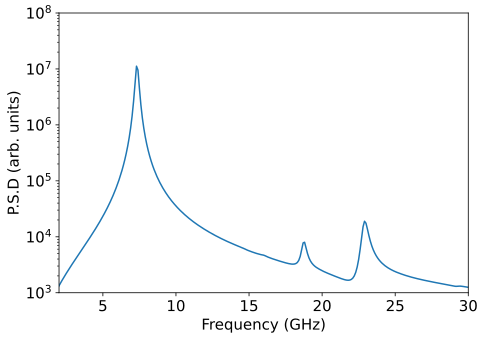

In [13]:
plot_power(power)

Plot the spatially resolved power

In [14]:
matplotlib.rcParams.update({'font.size': 15})
def plot_spatially_resolved(power, phase, f):
    def custom_sel(xarray):
        return xarray.sel(freq_t=f, method="nearest").sel(vdims="z")

    power_s = custom_sel(power)
    phase_s = custom_sel(phase)

    opacity = (power_s - power_s.min()) / (power_s.max() - power_s.min())

    dx = phase_s.coords["x"][1] - phase_s.coords["x"][0]
    dy = phase_s.coords["y"][1] - phase_s.coords["y"][0]

    # Plot the image with opacity
    fig, ax = plt.subplots()
    img = ax.imshow(
        phase_s,
        cmap="hsv",
        alpha=opacity.values.squeeze(),
        origin="lower",
        extent=[
            phase_s.coords["x"].min() - dx / 2,
            phase_s.coords["x"].max() + dx / 2,
            phase_s.coords["y"].min() - dy / 2,
            phase_s.coords["y"].max() + dy / 2,
        ],
        interpolation="spline16",
    )
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x*1e9:g}"))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x*1e9:g}"))
    ax.set_xlabel("x (nm)")
    ax.set_ylabel("y (nm)")
    plt.colorbar(img, label="Phase (rad)")
    fig.tight_layout()
    plt.show()

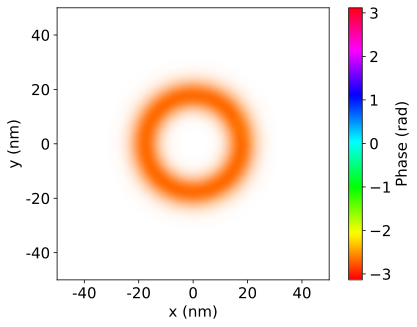

In [15]:
plot_spatially_resolved(power, phase, 7.3e9)

Use `hvplot` for interactive plotting.

In [16]:
import hvplot.xarray

power.hvplot.image(x="x", y="y", colorbar=True, aspect="equal") + phase.hvplot.image(x="x", y="y", colorbar=True, aspect="equal", cmap="hsv")

BokehModel(combine_events=True, render_bundle={'docs_json': {'5f33c615-2d9f-4e18-ba53-548d25e6fdc5': {'version…